For Pretraining Temperature: You could experiment with different values of pretraining_tp and observe how it affects the behavior of the model during training or inference, especially if sampling methods are used.

Dataset: https://huggingface.co/datasets/tatsu-lab/alpaca
Alpaca is a dataset of 52,000 instructions and demonstrations generated by OpenAI's text-davinci-003 engine. This instruction data can be used to conduct instruction-tuning for language models and make the language model follow instruction better.

The authors built on the data generation pipeline from Self-Instruct framework and made the following modifications:

The text-davinci-003 engine to generate the instruction data instead of davinci.
A new prompt was written that explicitly gave the requirement of instruction generation to text-davinci-003.
Much more aggressive batch decoding was used, i.e., generating 20 instructions at once, which significantly reduced the cost of data generation.
The data generation pipeline was simplified by discarding the difference between classification and non-classification instructions.
Only a single instance was generated for each instruction, instead of 2 to 3 instances as in Self-Instruct.
This produced an instruction-following dataset with 52K examples obtained at a much lower cost (less than $500). In a preliminary study, the authors also found that the 52K generated data to be much more diverse than the data released by Self-Instruct.

Supported Tasks and Leaderboards
The Alpaca dataset designed for instruction training pretrained language models.

Languages
The data in Alpaca are in English (BCP-47 en).

Dataset Structure
Data Instances
An example of "train" looks as follows:



In [1]:
"""{
    "instruction": "Create a classification task by clustering the given list of items.",
    "input": "Apples, oranges, bananas, strawberries, pineapples",
    "output": "Class 1: Apples, Oranges\nClass 2: Bananas, Strawberries\nClass 3: Pineapples",
    "text": "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nCreate a classification task by clustering the given list of items.\n\n### Input:\nApples, oranges, bananas, strawberries, pineapples\n\n### Response:\nClass 1: Apples, Oranges\nClass 2: Bananas, Strawberries\nClass 3: Pineapples",
}"""

'{\n    "instruction": "Create a classification task by clustering the given list of items.",\n    "input": "Apples, oranges, bananas, strawberries, pineapples",\n    "output": "Class 1: Apples, Oranges\nClass 2: Bananas, Strawberries\nClass 3: Pineapples",\n    "text": "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nCreate a classification task by clustering the given list of items.\n\n### Input:\nApples, oranges, bananas, strawberries, pineapples\n\n### Response:\nClass 1: Apples, Oranges\nClass 2: Bananas, Strawberries\nClass 3: Pineapples",\n}'

In [2]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.9 MB/s eta 0:00:00


In [3]:
!pip install -q git+https://github.com/huggingface/datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00


In [4]:
!pip install -q git+https://github.com/huggingface/peft

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.0 MB/s eta 0:00:00


In [5]:
!pip install -q git+https://github.com/huggingface/accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
!pip install -q --upgrade bitsandbytes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 18.6 MB/s eta 0:00:00


In [7]:
!pip install -q git+https://github.com/huggingface/trl

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [8]:
!pip install -q --upgrade safetensors

In [9]:
!pip install -q ipython-autotime
%load_ext autotime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.9 MB/s eta 0:00:00
time: 336 µs (started: 2023-09-09 15:53:10 +00:00)


In [10]:
from datasets import load_dataset
from random import randrange

# Load dataset from the hub
dataset = load_dataset("tatsu-lab/alpaca", split="train")





Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

time: 9.31 s (started: 2023-09-09 15:53:10 +00:00)


In [11]:
print(f"dataset size: {len(dataset)}")
print(dataset[randrange(len(dataset))])

dataset size: 52002
{'instruction': 'For the given sentence, replace the adjective with a synonym.', 'input': 'She walked down the narrow hallway.', 'output': 'She walked down the snug hallway.', 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nFor the given sentence, replace the adjective with a synonym.\n\n### Input:\nShe walked down the narrow hallway.\n\n### Response:\nShe walked down the snug hallway.'}
time: 1.11 ms (started: 2023-09-09 15:53:19 +00:00)


In [12]:
dataset

Dataset({
    features: ['instruction', 'input', 'output', 'text'],
    num_rows: 52002
})

time: 2.64 ms (started: 2023-09-09 15:53:19 +00:00)


In [13]:
# Rename columns in the dataset
dataset = dataset.rename_column('input', 'context')
dataset = dataset.rename_column('output', 'response')
dataset = dataset.rename_column('text', 'category')

time: 7.38 ms (started: 2023-09-09 15:53:19 +00:00)


In [14]:
dataset

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 52002
})

time: 2.45 ms (started: 2023-09-09 15:53:19 +00:00)


To instruct tune our model, we need to convert our structured examples into a collection of tasks described via instructions. We define a formatting_function that takes a sample and returns a string with our format instruction.

In [15]:
def format_instruction(sample):
	return f"""### Instruction:
Use the Input below to create an instruction, which could have been used to generate the input using an LLM.

### Input:
{sample['response']}

### Response:
{sample['instruction']}
"""


time: 473 µs (started: 2023-09-09 15:53:19 +00:00)


# **Testing Formatting Function on a Random Example**

In [16]:
from random import randrange

print(format_instruction(dataset[randrange(len(dataset))]))



### Instruction:
Use the Input below to create an instruction, which could have been used to generate the input using an LLM.

### Input:
1. coastal flooding, erosion and loss of wetlands
2. increased salinity intrusion of coastal aquifers
3. increased severity and frequency of storm surges
4. endangering of human life, property and infrastructure
5. disruption of traditional livelihoods
6. displacement of human populations
7. increased stress on freshwater resources
8. migration of marine and terrestrial species

### Response:
List the consequences of sea level rise.

time: 1.08 ms (started: 2023-09-09 15:53:19 +00:00)


In [17]:
print(dataset[0].keys())


dict_keys(['instruction', 'context', 'response', 'category'])
time: 953 µs (started: 2023-09-09 15:53:19 +00:00)


QLoRA is a new technique to reduce the memory footprint of large language models during finetuning, without sacrificing performance. The TL;DR; of how QLoRA works is:

Quantize the pre-trained model to 4 bits and freeze it.
Attach small, trainable adapter layers. (LoRA)
Finetune only the adapter layers while using the frozen quantized model for context.

Flash Attention is a an method that reorders the attention computation and leverages classical techniques (tiling, recomputation) to significantly speed it up and reduce memory usage from quadratic to linear in sequence length. It is based on the paper "FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness". The TL;DR; accelerates training up to 3x. Learn more at FlashAttention. Flash Attention is currently only available for Ampere (A10, A40, A100, ...) & Hopper (H100, ...) GPUs.

In [18]:
!python -c "import torch; assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'"
!pip install ninja packaging
!MAX_JOBS=4 pip install flash-attn --no-build-isolation


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.3 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.2.1-cp310-cp310-linux_x86_64.whl size=193960420 sha256=90f73bf1b0351f988d545836abd0f27aca8f72040720003809003b0ed40685a0
  Stored in directory: /root/.cache/pip/wheels/29/3d/d0/ca80c9c6061afa997cd0246a982fd905ef3a1837c8442a0050
Successfully built flash-attn
time: 27.8 s (started: 2023-09-09 15:53:19 +00:00)


# **Importing Necessary Libraries**

In [21]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

time: 388 µs (started: 2023-09-09 15:55:38 +00:00)


# **Flash Attention Flag and Checking Device Capability and Patching**

In [22]:
use_flash_attention = True

if torch.cuda.get_device_capability()[0] >= 8:
    from utils.llama_patch import replace_attn_with_flash_attn
    print("Using flash attention")
    replace_attn_with_flash_attn()
    use_flash_attention = True

Using flash attention
time: 4.18 s (started: 2023-09-09 15:56:21 +00:00)


# **Model ID Specification**

In [23]:
# Hugging Face model id
model_id = "NousResearch/Llama-2-7b-hf"

time: 382 µs (started: 2023-09-09 15:56:25 +00:00)


# **BitsAndBytesConfig Setup**

In [24]:
# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

time: 1.95 ms (started: 2023-09-09 15:56:25 +00:00)


In [25]:
import torch
torch.cuda.empty_cache()


time: 463 µs (started: 2023-09-09 15:56:25 +00:00)


# **Loading Model and Tokenizer**

In [26]:
# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, use_cache=False, device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

time: 1min 6s (started: 2023-09-09 15:56:25 +00:00)


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [27]:
model.config

LlamaConfig {
  "_name_or_path": "NousResearch/Llama-2-7b-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.3

time: 3 ms (started: 2023-09-09 15:57:32 +00:00)


In [28]:
model.config.pretraining_tp = 2

time: 311 µs (started: 2023-09-09 15:57:32 +00:00)


In [29]:
model.config

LlamaConfig {
  "_name_or_path": "NousResearch/Llama-2-7b-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 2,
  "quantization_config": {
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.3

time: 2.55 ms (started: 2023-09-09 15:57:32 +00:00)


# **Validation Step to Ensure that the Model is Indeed Using the Flash Attention Mechanism**

In [30]:
# Validate that the model is using flash attention, by comparing doc strings
if use_flash_attention:
    from utils.llama_patch import forward
    assert model.model.layers[0].self_attn.forward.__doc__ == forward.__doc__, "Model is not using flash attention"

time: 309 µs (started: 2023-09-09 15:57:32 +00:00)


In [31]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

time: 3.19 s (started: 2023-09-09 15:57:32 +00:00)


In [32]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

# LoRA config based on QLoRA paper
peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.1,
        r=64,
        bias="none",
        task_type="CAUSAL_LM",
)


# prepare model for training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)


time: 8.83 s (started: 2023-09-09 15:57:35 +00:00)


In [33]:
model.config

LlamaConfig {
  "_name_or_path": "NousResearch/Llama-2-7b-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.3

time: 3.44 ms (started: 2023-09-09 15:57:44 +00:00)


In [34]:
from utils.llama_patch import upcast_layer_for_flash_attention
model = upcast_layer_for_flash_attention(model, torch.bfloat16)

time: 12.8 ms (started: 2023-09-09 15:57:44 +00:00)


In [35]:
model.config

LlamaConfig {
  "_name_or_path": "NousResearch/Llama-2-7b-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.3

time: 2.97 ms (started: 2023-09-09 15:57:44 +00:00)


# **Instantiate LoRAConfig and Prepare Model for Training**

In [36]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="llama-7-int4-alpaca-flash-attention-tp-2",
    num_train_epochs=2,
    per_device_train_batch_size=6 if use_flash_attention else 4,
    optim="paged_adamw_32bit",
    logging_steps=200,
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=True,
    tf32=True,
    lr_scheduler_type="constant",
    disable_tqdm=True # disable tqdm since with packing values are in correct
)

time: 3.46 ms (started: 2023-09-09 15:57:44 +00:00)


In [37]:
from trl import SFTTrainer

max_seq_length = 2048 # max sequence length for model and packing of the dataset

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    packing=True,
    formatting_func=format_instruction,
    args=args,
)


time: 210 ms (started: 2023-09-09 15:57:44 +00:00)


In [38]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.9382, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 0.8903, 'learning_rate': 0.0002, 'epoch': 0.05}
{'loss': 0.8715, 'learning_rate': 0.0002, 'epoch': 1.01}
{'loss': 0.8662, 'learning_rate': 0.0002, 'epoch': 1.03}
{'loss': 0.8648, 'learning_rate': 0.0002, 'epoch': 1.06}
{'train_runtime': 3706.0637, 'train_samples_per_second': 28.063, 'train_steps_per_second': 4.677, 'train_loss': 0.8854536433595156, 'epoch': 1.06}


TrainOutput(global_step=1042, training_loss=0.8854536433595156, metrics={'train_runtime': 3706.0637, 'train_samples_per_second': 28.063, 'train_steps_per_second': 4.677, 'train_loss': 0.8854536433595156, 'epoch': 1.06})

time: 1h 1min 46s (started: 2023-09-09 15:57:44 +00:00)


In [39]:
from huggingface_hub import notebook_login
notebook_login()

time: 17 ms (started: 2023-09-09 16:59:30 +00:00)


In [41]:
trainer.push_to_hub()

training_args.bin:   0%|          | 0.00/4.16k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/67.2M [00:00<?, ?B/s]

'https://huggingface.co/DrishtiSharma/llama-7-int4-alpaca-flash-attention-tp-2/tree/main/'

time: 13.3 s (started: 2023-09-09 17:13:43 +00:00)


# **Test Model and run Inference**

In [42]:
if use_flash_attention:
    # unpatch flash attention
    from utils.llama_patch import unplace_flash_attn_with_attn
    unplace_flash_attn_with_attn()

import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer


# load base LLM model and tokenizer
model = AutoPeftModelForCausalLM.from_pretrained(
    args.output_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)
tokenizer = AutoTokenizer.from_pretrained(args.output_dir)


Reloading llama model, unpatching flash attention


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


time: 14.8 s (started: 2023-09-09 17:14:25 +00:00)


In [43]:
sample = dataset[randrange(len(dataset))]

prompt = f"""### Instruction:
Use the Input below to create an instruction, which could have been used to generate the input using an LLM.

### Input:
{sample['response']}

### Response:
"""

input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
# with torch.inference_mode():
outputs = model.generate(input_ids=input_ids, max_new_tokens=100, do_sample=True, top_p=0.9,temperature=0.9)

print(f"Prompt:\n{sample['response']}\n")
print(f"Generated instruction:\n{tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}")
print(f"Ground truth:\n{sample['instruction']}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:224: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')


Prompt:
The COVID-19 pandemic had a major impact on the food industry in 20

Generated instruction:
Generate a new sentence that starts with the phrase "The COVID-19 pandemic had a major impact on..."

Ground truth:
Analyze how 2020 impacted the food industry.
time: 3.61 s (started: 2023-09-09 17:14:40 +00:00)


Nice! our model works! If want to accelerate our model we can deploy it with Text Generation Inference. Therefore we would need to merge our adapter weights into the base model.

In [44]:
from peft import AutoPeftModelForCausalLM

model = AutoPeftModelForCausalLM.from_pretrained(
    args.output_dir,
    low_cpu_mem_usage=True,
)

# Merge LoRA and base model
merged_model = model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")

# push merged model to the hub
merged_model.push_to_hub("DrishtiSharma/llama-2-7b-int4-alpaca-flash-attention-tp-2-merged")
tokenizer.push_to_hub("DrishtiSharma/llama-2-7b-int4-alpaca-flash-attention-tp-2-merged")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/9.88G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/9.89G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/7.18G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DrishtiSharma/llama-2-7b-int4-alpaca-flash-attention-tp-2-merged/commit/4c614c7c433adb94f9beebf285c24425c69f936c', commit_message='Upload tokenizer', commit_description='', oid='4c614c7c433adb94f9beebf285c24425c69f936c', pr_url=None, pr_revision=None, pr_num=None)

time: 21min 26s (started: 2023-09-09 17:14:46 +00:00)


In [45]:
"""# Assuming you've already loaded a model and tokenized input text
inputs = tokenizer("Hi, My name is Drishti", return_tensors="pt")
outputs = model(**inputs)
attentions = outputs.attentions
"""

time: 2.27 s (started: 2023-09-09 17:36:12 +00:00)


torch.Size([5, 5])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9934, 0.0066, 0.0000, 0.0000, 0.0000],
        [0.9798, 0.0047, 0.0155, 0.0000, 0.0000],
        [0.9641, 0.0040, 0.0108, 0.0211, 0.0000],
        [0.7923, 0.0310, 0.0326, 0.0542, 0.0898]])


<Axes: >

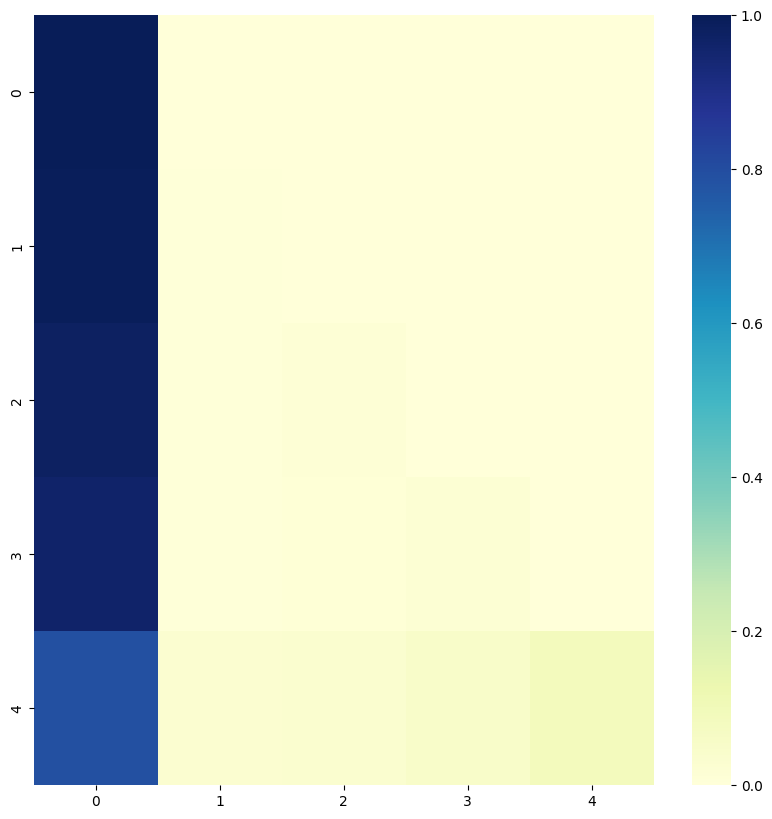

time: 1.35 s (started: 2023-09-09 17:38:54 +00:00)


In [48]:

inputs = tokenizer("Your input text here", return_tensors="pt")
outputs = outputs = model(**inputs, output_attentions=True)


attentions = outputs.attentions

import matplotlib.pyplot as plt
import seaborn as sns

# Check the shape and values first
print(attentions[-1][0][0].shape)
print(attentions[-1][0][0])

# If the structure looks okay, proceed to visualize
attention_matrix = attentions[-1][0][0].detach().numpy()

plt.figure(figsize=(10,10))
sns.heatmap(attention_matrix, cmap="YlGnBu")
